In [30]:
#!pip install matplotlib
#!pip install mplcyberpunk
#!pip install setuptools
from matplotlib import pyplot as plt
import math
import mplcyberpunk

plt.style.use("cyberpunk")


# Analisys for the WATTIMETER

This is a ESP32 project aimed to provide power consumption information for the network. 

The project will use:
* ESP32
* ACS712

## For the current sensing - ACS712
The project will use the ACS712 current sensor to be able to measure the current.
The ACS712 has very specific voltage-current graph as show bellow:
![acs712](current_sensor.png)

Since the 0A is exactly at 2.5V for the output, we will need to adjust our code. I have no intention of moving this values to increase resolution, the reason behind it is to minimise components in the circuitry.

The equation for the current is:
$$
A = \frac{(A_1 + A_2 + A_3 + ... + A_n)}{A_n}
$$

For the Arms the equation is:
$$
A_{rms} = \sqrt{\frac{A_1^2 + A_2^2 + A_3^2 + ... + A_n^2}{n}}
$$

For the ADC in the ESP32 we need to be able to read the actual current value, so we know that:
* ESP32 adc has 3.3v
* 12bit adc 4095

This means we have better resolution setting up oue sensor to read negative current, from 0A to -30A

The equation for the datasheet graph is:
$$
V = A*0.1 + 2.5
$$

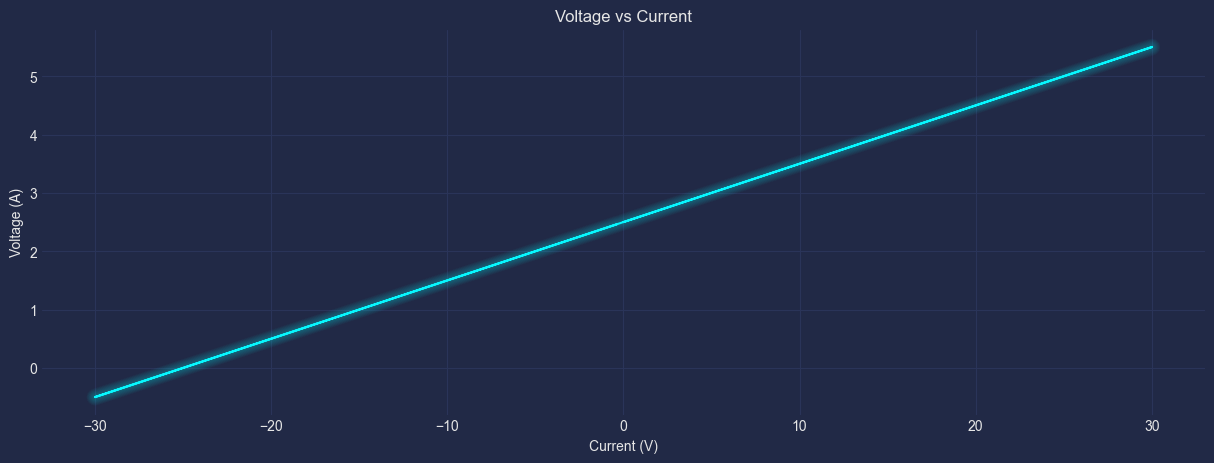

In [46]:
A = []
V = []
f = 60
t = 1/f
Res = 1000

for i in range(0, Res):
    A.append(30 * math.sin(2*math.pi*f*i/(30*Res)))
    V.append(A[i]*0.1 + 2.5)    


fig = plt.figure()
fig.set_size_inches(15, 5)
plt.plot(A, V)
plt.title('Voltage vs Current')
plt.xlabel('Current (V)')
plt.ylabel('Voltage (A)')

mplcyberpunk.make_lines_glow()
plt.show()

## ESP32 adc
For the esp32 adc to be able to read correct values:
```
Vadc = Raw * 3.3 / 4095
V = (Vadc - 2.5)/0.1
```